<hr style="border: solid 3px blue;">

# Introduction

> The data used is a compilation of different vehicles from the year 2019 to 2020 in one of the Mill road Network in the United Kingdom. We want to predict the time series through the RNN model made of simple LTSM, GRU, Prophet and Seasonal AutoRegressive Integrated Moving Average with eXogenous Factors (SARIMAX) .

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

import torch
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


In [2]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

In [3]:
#Loading Data
data = pd.read_csv("/content/Data.csv")
data.head()

,LocalTime,Date,Time,countlineName,direction,Car,Pedestrian,Cyclist,Motorbike,Bus,OGV1,OGV2,LGV
0,3/6/2019 1:00,3/6/2019,1:00:00,S10_EastRoad_CAM003,in,89,9,4,2,1,0,0,5
1,3/6/2019 2:00,3/6/2019,2:00:00,S10_EastRoad_CAM003,in,34,4,1,0,0,0,0,5
2,3/6/2019 3:00,3/6/2019,3:00:00,S10_EastRoad_CAM003,in,42,3,2,0,0,0,0,6
3,3/6/2019 4:00,3/6/2019,4:00:00,S10_EastRoad_CAM003,in,39,2,8,2,0,0,0,5
4,3/6/2019 5:00,3/6/2019,5:00:00,S10_EastRoad_CAM003,in,85,2,9,1,1,3,1,15


In [4]:
data.columns


Index(['LocalTime', 'Date', 'Time', 'countlineName', 'direction', 'Car',
       'Pedestrian', 'Cyclist', 'Motorbike', 'Bus', 'OGV1', 'OGV2', 'LGV'],
      dtype='object')

<a id="3"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>
* Pharsing dates
* Ploting timeseris
* Feature engineering for EDA

In [5]:
data["LocalTime"]= pd.to_datetime(data["LocalTime"],format='%d/%m/%Y %H:%M')
data = data.drop(["Pedestrian","Cyclist","Motorbike","Bus","OGV1","OGV2","LGV","Date","Time"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832 entries, 0 to 5831
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   LocalTime      5832 non-null   datetime64[ns]
 1   countlineName  5832 non-null   object        
 2   direction      5832 non-null   object        
 3   Car            5832 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 182.4+ KB


<ipython-input-6-887fb07a5c27>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  Time_series=sns.lineplot(x=df['LocalTime'],y="Car",data=df, hue="direction", palette=colors)


Text(0.5, 0, 'Date')

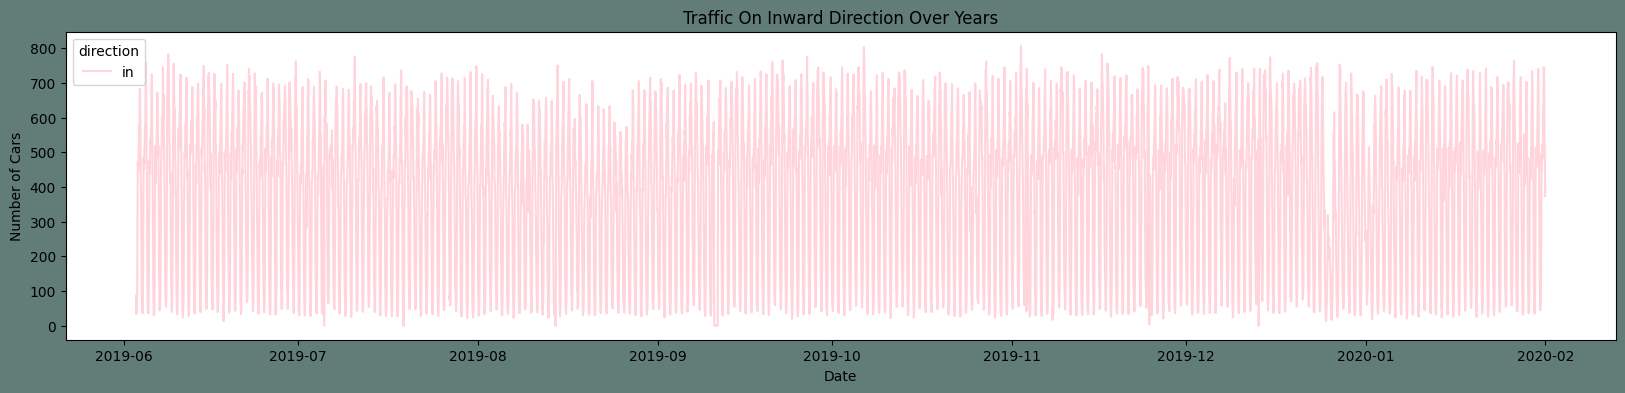

In [6]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['LocalTime'],y="Car",data=df, hue="direction", palette=colors)
Time_series.set_title("Traffic On Inward Direction Over Years")
Time_series.set_ylabel("Number of Cars")
Time_series.set_xlabel("Date")

<a id="3.1"></a>
# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Feature Engineering</p>

At this step, I am creating a few new features out of Local Time (Sensor).
Namely:
* Year
* Date in the given month
* Month
* Hour

In [7]:
#Exploring more features
df["Year"]= df['LocalTime'].dt.year
df["Date_no"]= df['LocalTime'].dt.day
df["Month"]= df['LocalTime'].dt.month
df["Hour"]= df['LocalTime'].dt.hour
df["Day"]= df.LocalTime.dt.strftime("%A")
df.head()

,LocalTime,countlineName,direction,Car,Year,Date_no,Month,Hour,Day
0,2019-06-03 01:00:00,S10_EastRoad_CAM003,in,89,2019,3,6,1,Monday
1,2019-06-03 02:00:00,S10_EastRoad_CAM003,in,34,2019,3,6,2,Monday
2,2019-06-03 03:00:00,S10_EastRoad_CAM003,in,42,2019,3,6,3,Monday
3,2019-06-03 04:00:00,S10_EastRoad_CAM003,in,39,2019,3,6,4,Monday
4,2019-06-03 05:00:00,S10_EastRoad_CAM003,in,85,2019,3,6,5,Monday


In [8]:
df = df.drop(["LocalTime"], axis=1)

<ipython-input-9-be60952e2fa9>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax=sns.lineplot(x=df[i],y="Car",data=df, hue="direction", palette=colors )
<ipython-input-9-be60952e2fa9>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax=sns.lineplot(x=df[i],y="Car",data=df, hue="direction", palette=colors )
<ipython-input-9-be60952e2fa9>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax=sns.lineplot(x=df[i],y="Car",data=df, hue="direction", palette=colors )
<ipython-input-9-be60952e2fa9>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax=sns.lineplot(x=df[i],y="Car",data=df, hue="direction", palette=colors )
<ipython-input-9-be60952e2fa9>:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax=sns.lineplot(x=df[i],y="Car",data=df, hue="dire

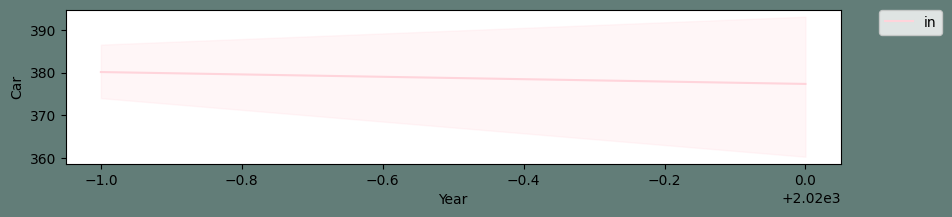

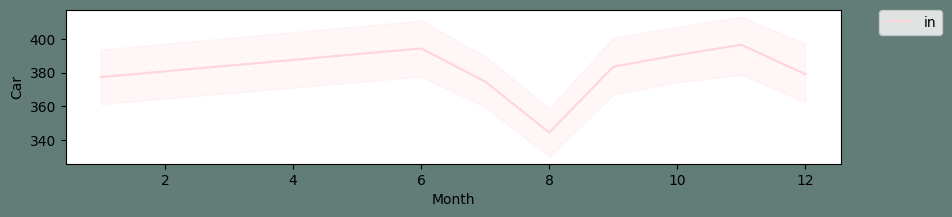

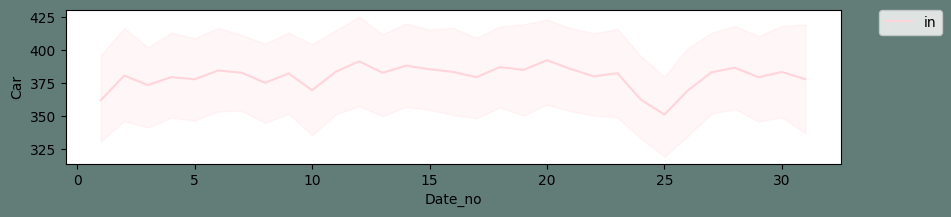

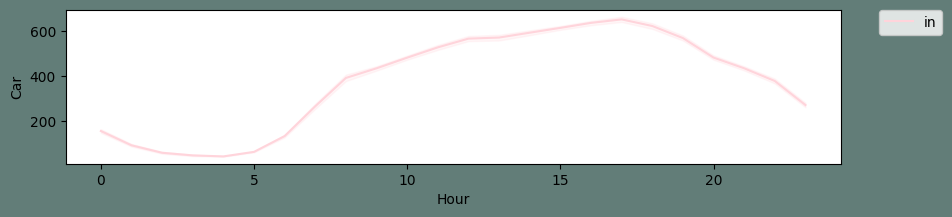

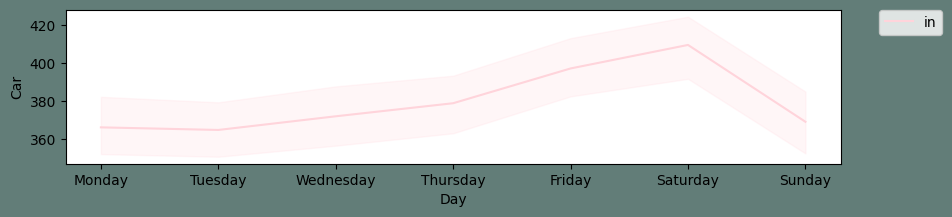

In [9]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour","Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Car",data=df, hue="direction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [10]:
cm = sns.light_palette("green", as_cmap=True)
df.head(25).style.background_gradient(cmap=cm)

,countlineName,direction,Car,Year,Date_no,Month,Hour,Day
0,S10_EastRoad_CAM003,in,89,2019,3,6,1,Monday
1,S10_EastRoad_CAM003,in,34,2019,3,6,2,Monday
2,S10_EastRoad_CAM003,in,42,2019,3,6,3,Monday
3,S10_EastRoad_CAM003,in,39,2019,3,6,4,Monday
4,S10_EastRoad_CAM003,in,85,2019,3,6,5,Monday
5,S10_EastRoad_CAM003,in,161,2019,3,6,6,Monday
6,S10_EastRoad_CAM003,in,319,2019,3,6,7,Monday
7,S10_EastRoad_CAM003,in,472,2019,3,6,8,Monday
8,S10_EastRoad_CAM003,in,462,2019,3,6,9,Monday
9,S10_EastRoad_CAM003,in,458,2019,3,6,10,Monday


In [11]:
print(df.describe())
print('-'*40)
print(df.tail())

               Car         Year      Date_no        Month         Hour
count  5832.000000  5832.000000  5832.000000  5832.000000  5832.000000
mean    379.757373  2019.127572    15.938272     8.008916    11.500171
std     226.596576     0.333641     8.782767     3.259947     6.922508
min       0.000000  2019.000000     1.000000     1.000000     0.000000
25%     142.000000  2019.000000     8.000000     7.000000     5.750000
50%     439.000000  2019.000000    16.000000     9.000000    11.500000
75%     565.000000  2019.000000    24.000000    11.000000    17.250000
max     807.000000  2020.000000    31.000000    12.000000    23.000000
----------------------------------------
            countlineName direction  Car  Year  Date_no  Month  Hour     Day
5827  S10_EastRoad_CAM003        in  706  2020       31      1    19  Friday
5828  S10_EastRoad_CAM003        in  540  2020       31      1    20  Friday
5829  S10_EastRoad_CAM003        in  511  2020       31      1    21  Friday
5830  S10_Ea

In [12]:
df.shape

(5832, 8)

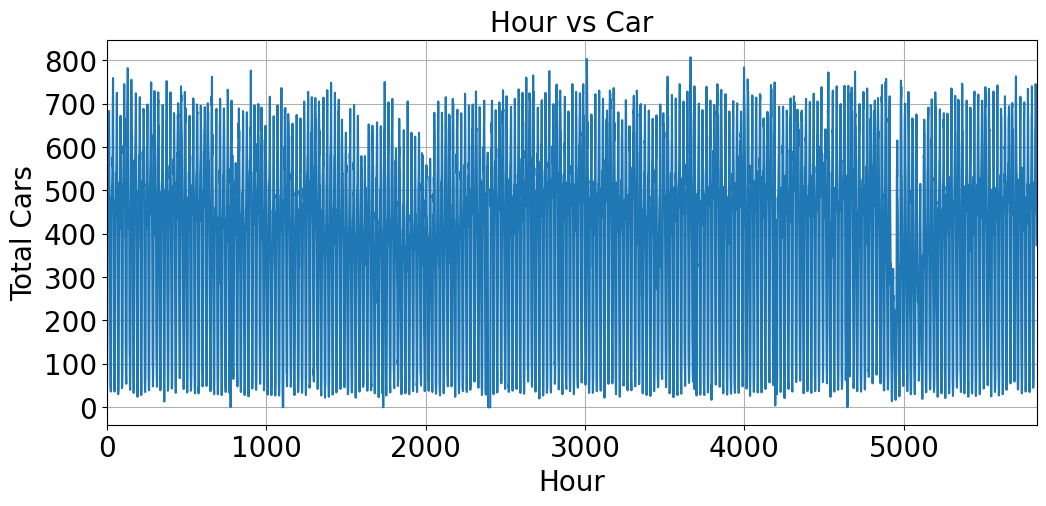

In [13]:
plt.figure(figsize=(12,5))
plt.title('Hour vs Car',fontsize = 20)
plt.ylabel('Total Cars',fontsize = 20)
plt.xlabel('Hour',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df['Car'])

If you look at the picture above, you can see the periodicity by season. Let's analyze it a bit more using seasonal_decompose,

In [14]:
df['Car']

0        89
1        34
2        42
3        39
4        85
       ... 
5827    706
5828    540
5829    511
5830    445
5831    374
Name: Car, Length: 5832, dtype: int64

Let's decompose time series data into Trend, Seasonality, and Residual through time series decomposition.

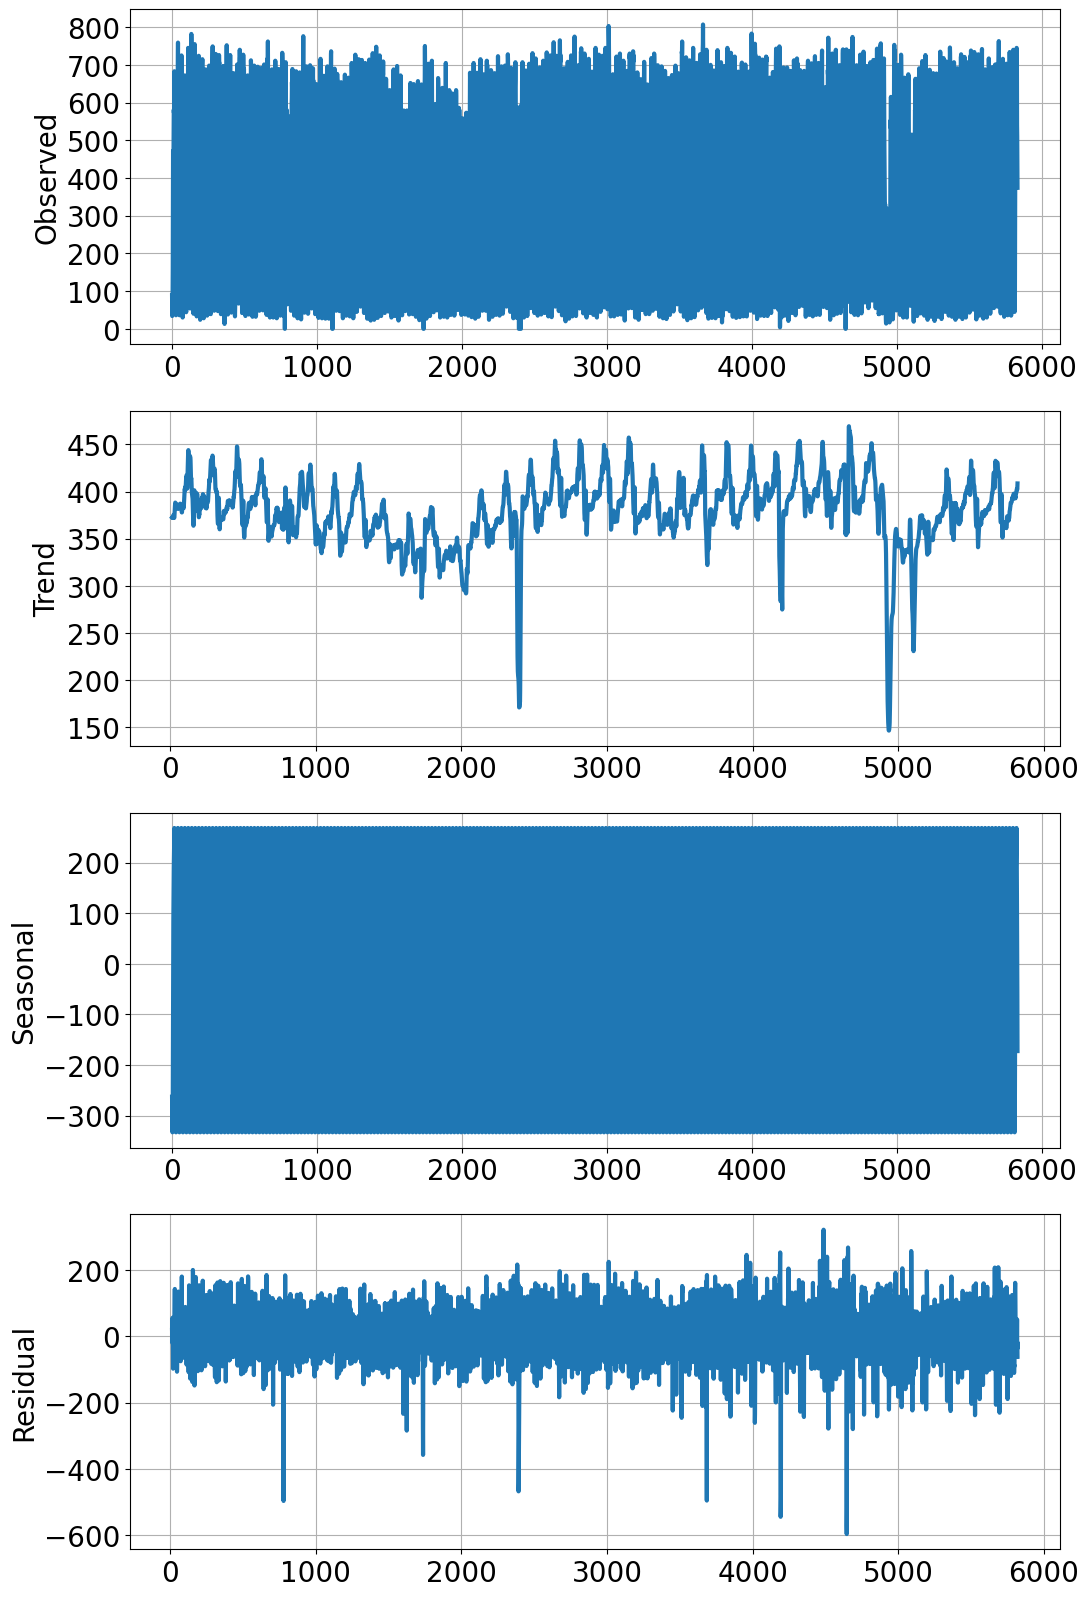

In [15]:
decomposition = seasonal_decompose(df['Car'], period=24)
plot_decompose(decomposition)

As expected, seasonal periodicity was observed. Let's see if our predictive model can learn this periodicity and make a prediction. Also, if you look at the trend line, you can see that the number of cars is fluctuating.

## **Missing Value treatment**

In [16]:
df.isnull().sum()

countlineName    0
direction        0
Car              0
Year             0
Date_no          0
Month            0
Hour             0
Day              0
dtype: int64

## Checking duplicates

In [17]:
df.duplicated().sum()

0

### Outlier Check

- Let's check for outliers in the data.

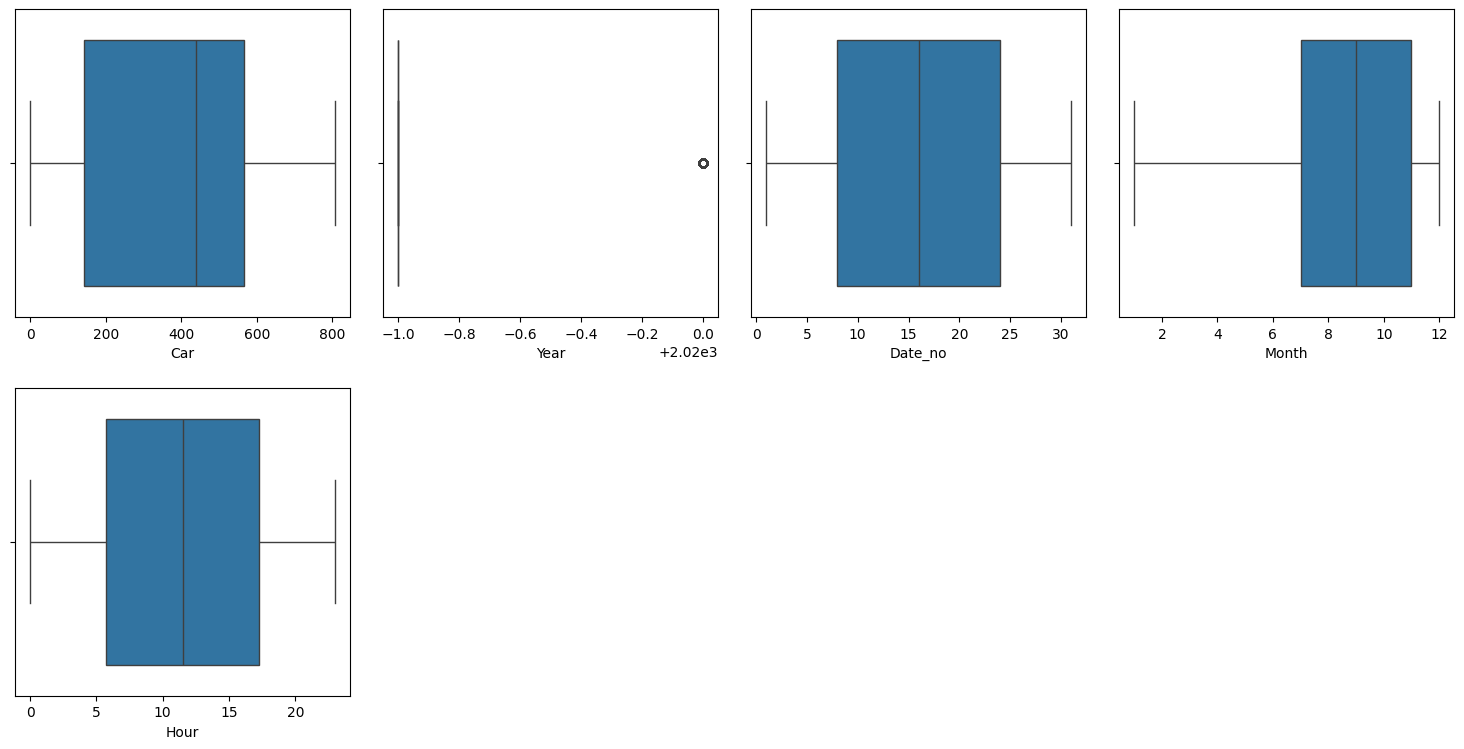

In [18]:
# outlier detection using boxplot
num_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 15))

for i, variable in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data=df, x=variable)
    plt.tight_layout(pad=2)

plt.show()

### Treating Outliers

In [19]:
# functions to treat outliers by flooring and capping


def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

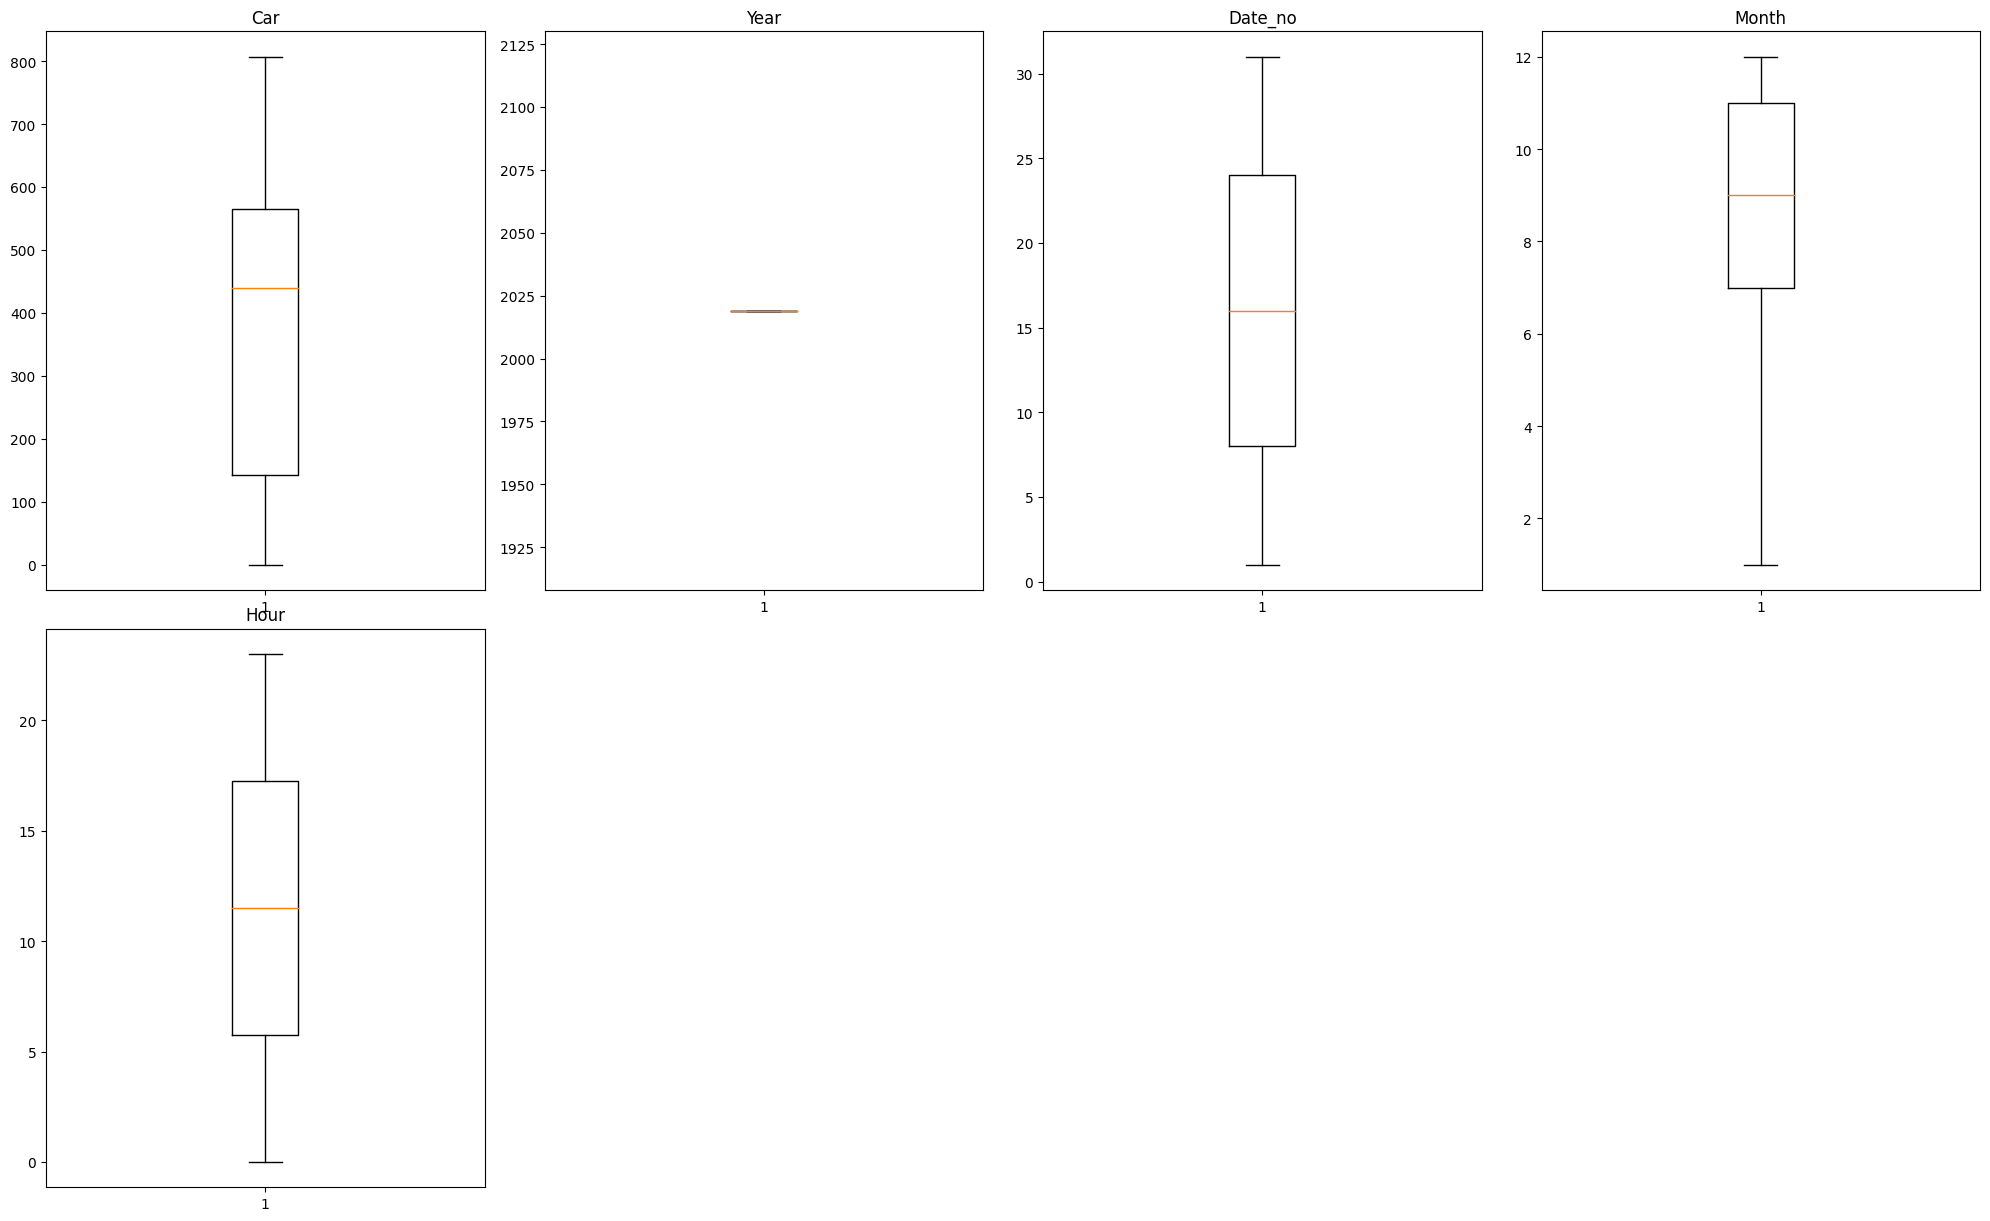

In [20]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df, numerical_col)
# let's look at box plot to see if outliers have been treated or not
plt.figure(figsize=(20, 30))

for i, variable in enumerate(numerical_col):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

# Preprocessing

In [21]:
df = df['Car'].values.astype(float)
print(df)

[ 89.  34.  42. ... 511. 445. 374.]


In [22]:
test_data_size = 24

train_data = df[:-test_data_size]
test_data = df[-test_data_size:]

In [23]:
print(len(train_data))
print(len(test_data))

5808
24


Perform Min-Max scaling.

In this case, the distribution of the dataset is maintained through linear transformation.

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [25]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

# Utility Function

> This function returns a tuple by transforming the raw input data into sequence data to fit training. The number of cars traveling in the first 24 hours predicts the number of cars in the next 24 hours.
>
> The first value in tuple: sequence of cars in 24 hours (=features)
>
> The second value of the tuple: the number of cars predicted as the number of cars in 24 hours (=target)

In [26]:
train_window = 24

In [27]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [28]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [29]:
train_inout_seq[:5]

[(tensor([-0.7794, -0.9157, -0.8959, -0.9033, -0.7893, -0.6010, -0.2094,  0.1698,
           0.1450,  0.1351,  0.1177,  0.3358,  0.4399,  0.4201,  0.4374,  0.6753,
           0.6927,  0.5242,  0.4027,  0.0260,  0.0012, -0.2144, -0.4102, -0.6283]),
  tensor([-0.8290])),
 (tensor([-0.9157, -0.8959, -0.9033, -0.7893, -0.6010, -0.2094,  0.1698,  0.1450,
           0.1351,  0.1177,  0.3358,  0.4399,  0.4201,  0.4374,  0.6753,  0.6927,
           0.5242,  0.4027,  0.0260,  0.0012, -0.2144, -0.4102, -0.6283, -0.8290]),
  tensor([-0.8835])),
 (tensor([-0.8959, -0.9033, -0.7893, -0.6010, -0.2094,  0.1698,  0.1450,  0.1351,
           0.1177,  0.3358,  0.4399,  0.4201,  0.4374,  0.6753,  0.6927,  0.5242,
           0.4027,  0.0260,  0.0012, -0.2144, -0.4102, -0.6283, -0.8290, -0.8835]),
  tensor([-0.8934])),
 (tensor([-0.9033, -0.7893, -0.6010, -0.2094,  0.1698,  0.1450,  0.1351,  0.1177,
           0.3358,  0.4399,  0.4201,  0.4374,  0.6753,  0.6927,  0.5242,  0.4027,
           0.0260,  0.0012

# 1. Modeling using LSTM

![](https://miro.medium.com/max/1400/1*goJVQs-p9kgLODFNyhl9zA.gif)


> Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).
>
> A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
>
> LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

Modeling is done using a simple LTSM layer.

* Input_size: It corresponds to the number of input sequences. The sequence length is 24, but there is only 1 value per hour, i.e. total number of cars, so the input size is 1.
* Hidden_layer_size: Specifies the number of hidden layers.
* Output_size: The output size is 1 because the number of items in the output predicts the number of cars in the next 24 hours.

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [31]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [32]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [33]:
epochs = 101

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.00269871
epoch:  26 loss: 0.00007258
epoch:  51 loss: 0.00011086
epoch:  76 loss: 0.00000494
epoch: 100 loss: 0.00000305


# Predicting

The test set contains cars data for the last 24 hours. The model is trained to make predictions using sequence length 24. Let's predict the last 24 hours of data.

In [34]:
 fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.6703841090202332, -0.8438661694526672, -0.8785625696182251, -0.913258969783783, -0.8884758353233337, -0.7992565035820007, -0.5563816428184509, -0.0830235406756401, 0.27137547731399536, 0.20198264718055725, 0.14250309765338898, 0.1350681483745575, 0.16976456344127655, 0.26641884446144104, 0.3135068118572235, 0.4547707438468933, 0.6555142402648926, 0.6877323389053345, 0.8339529037475586, 0.7174721360206604, 0.44485750794410706, 0.2118959128856659, -0.10037174820899963, -0.40024784207344055]


In [35]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

Check the last 24 predictions.

In [36]:
test_inputs[fut_pred:]

[-0.6664863228797913,
 -0.8336947560310364,
 -0.8950856328010559,
 -0.9171926379203796,
 -0.9023339152336121,
 -0.8298010230064392,
 -0.584292471408844,
 -0.15598171949386597,
 0.20463940501213074,
 0.15632328391075134,
 0.1022239699959755,
 0.14589129388332367,
 0.14532364904880524,
 0.19970247149467468,
 0.26868200302124023,
 0.4799904525279999,
 0.6329320669174194,
 0.6991850733757019,
 0.7516273260116577,
 0.6240717768669128,
 0.3749319911003113,
 0.20000135898590088,
 0.009675294160842896,
 -0.39104798436164856]

# Converting to real values
Since we normalized the dataset for training, the predicted values are also normalized. We need to transform the normalized predicted values into the actual predicted values. Use the inverse_transform of the min/max scaler object you used to normalize the data set to transform it to its original value.

In [37]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[134.57276872]
 [ 67.10416594]
 [ 42.33294716]
 [ 33.4127706 ]
 [ 39.4082652 ]
 [ 68.67528722]
 [167.73798779]
 [340.56137618]
 [486.07199992]
 [466.57644506]
 [444.74737189]
 [462.36713708]
 [462.13809239]
 [484.07994725]
 [511.91318822]
 [597.1761476 ]
 [658.888089  ]
 [685.62117711]
 [706.78162605]
 [655.31296197]
 [554.78505841]
 [484.20054835]
 [407.40398119]
 [245.71213831]]


In [38]:
x = np.arange(5808,5832, 1)
print(x)

[5808 5809 5810 5811 5812 5813 5814 5815 5816 5817 5818 5819 5820 5821
 5822 5823 5824 5825 5826 5827 5828 5829 5830 5831]


# Checking results
The prediction of the LSTM is indicated by the orange line. Although the results are not exact, it is possible to spot an upward trend based on fluctuations in the total number of cars traveling over the past 24 hours. Better performance can be achieved by using a larger number of epochs and a larger number of neurons in the LSTM layer.

In [39]:
# Assuming df is a NumPy array
df = pd.DataFrame(df, columns=['Car'])

# Now you can use reset_index
df.reset_index(drop=True, inplace=True)

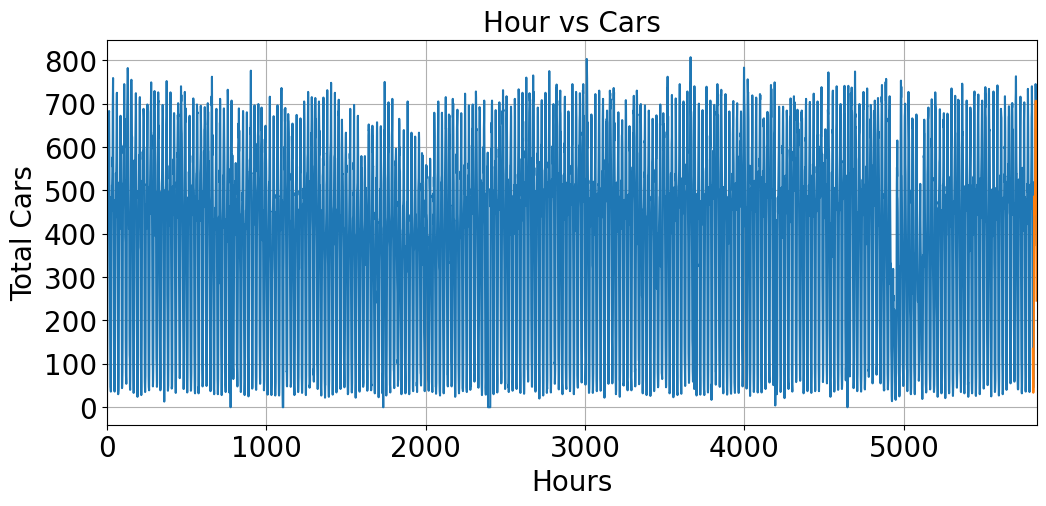

In [40]:
plt.figure(figsize=(12,5))
plt.title('Hour vs Cars',fontsize = 20)
plt.ylabel('Total Cars',fontsize = 20)
plt.xlabel('Hours',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df['Car'])
plt.plot(x,actual_predictions)

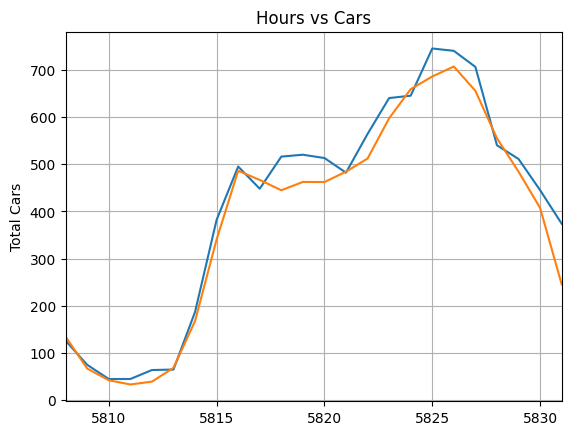

In [41]:
plt.title('Hours vs Cars')
plt.ylabel('Total Cars')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(df['Car'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

# Time series analysis with predicted results

Check whether the predicted results are learned while preserving the trend, seasonality, and residual of the timer series that the original time series has.

In [42]:
df['Car'][:-train_window]
train_df = pd.DataFrame(df['Car'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['Car']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

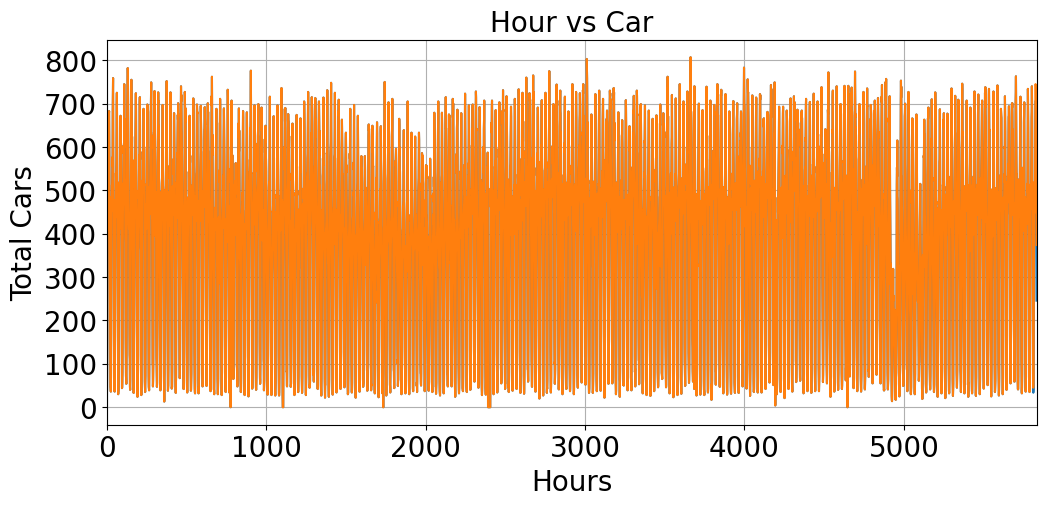

In [43]:
plt.figure(figsize=(12,5))
plt.title('Hour vs Car',fontsize = 20)
plt.ylabel('Total Cars',fontsize = 20)
plt.xlabel('Hours',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(df['Car'])

**Let's do a seasonal decomposition analysis with the predicted results.**

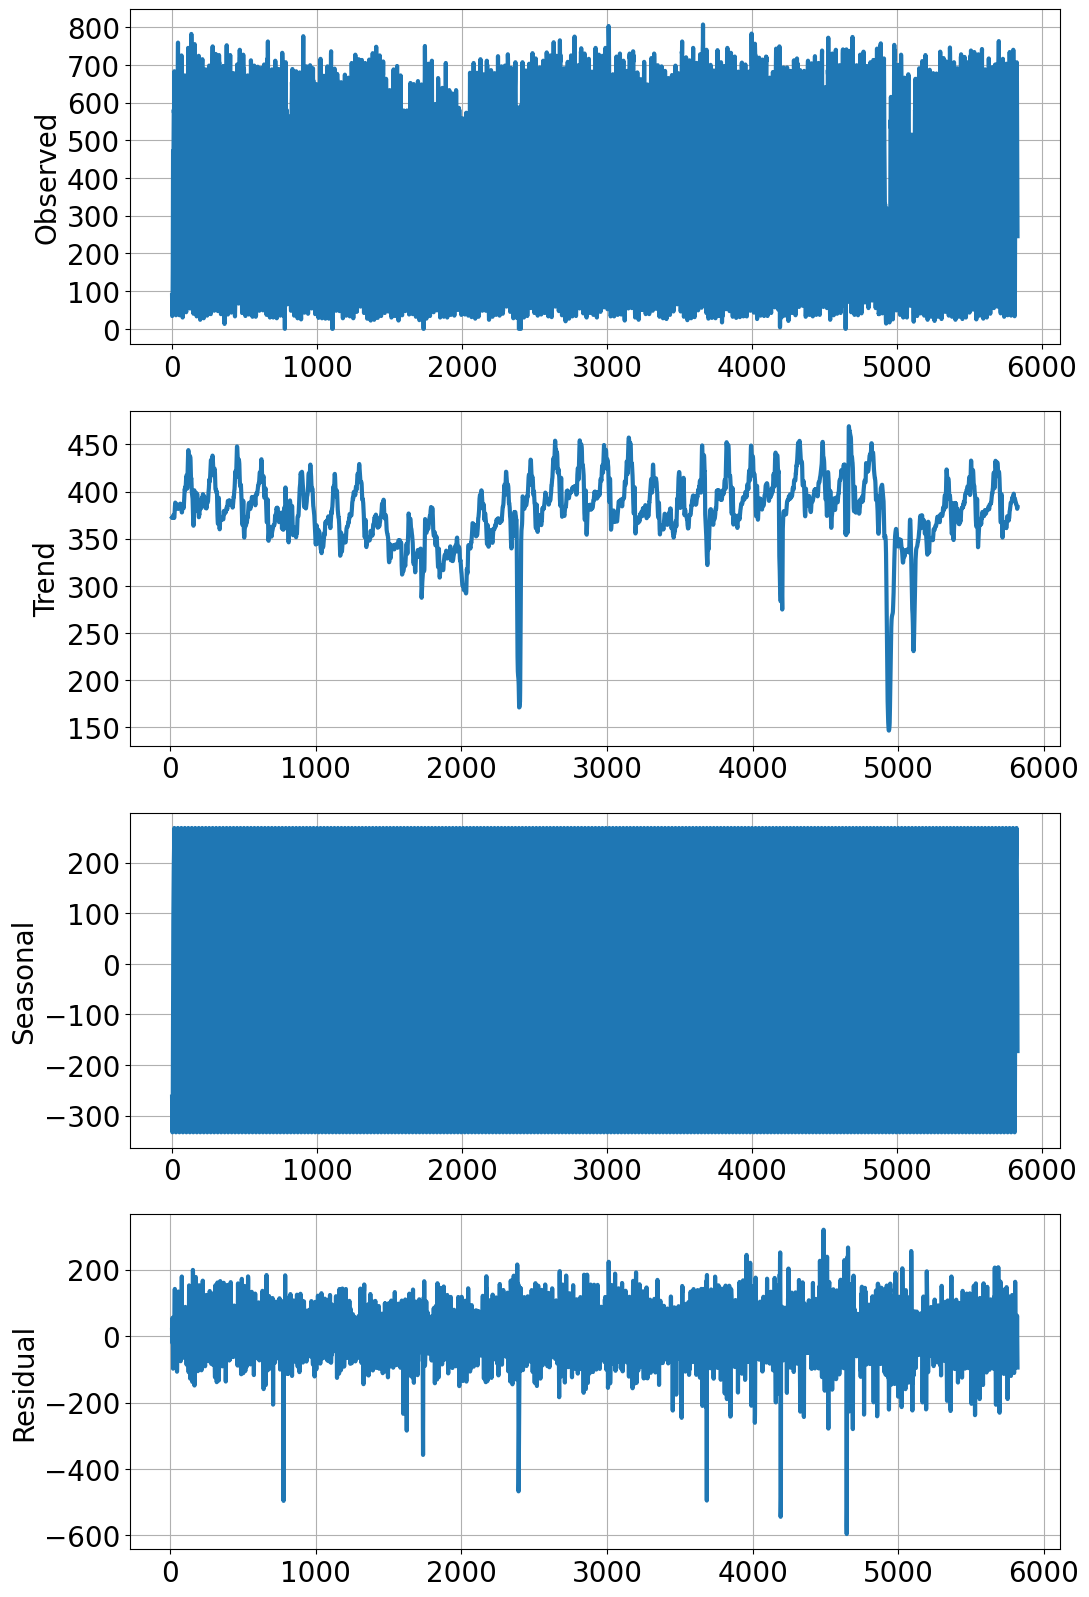

In [44]:
decomposition = seasonal_decompose(new_predict, period=24)
plot_decompose(decomposition)

# 2. Modelling Using Prophet  

In this section a Facebook's (now Meta) library called "Prophet" will be used.

In [58]:
from prophet import Prophet

Prophet requires from a database to contain two columns: `ds` for dates and `y` for values.

In [59]:
df = data.reset_index()
df = df.rename({'LocalTime':'ds', 'Car':'y'},axis=1)
df.head()

,index,ds,countlineName,direction,y
0,0,2019-06-03 01:00:00,S10_EastRoad_CAM003,in,89
1,1,2019-06-03 02:00:00,S10_EastRoad_CAM003,in,34
2,2,2019-06-03 03:00:00,S10_EastRoad_CAM003,in,42
3,3,2019-06-03 04:00:00,S10_EastRoad_CAM003,in,39
4,4,2019-06-03 05:00:00,S10_EastRoad_CAM003,in,85


Prophet follows a scikit learn scheme where we have to initialise an instance and then to fit it to a database. At the moment of initialisation it is possible to specifiy some additional parameters.

In [60]:
m = Prophet(changepoint_prior_scale=0.004,
                seasonality_prior_scale=20,
                seasonality_mode='multiplicative',
                changepoint_range=0.9)
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oktk2ue/9cmku_d7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oktk2ue/2w6q7k9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2391', 'data', 'file=/tmp/tmp6oktk2ue/9cmku_d7.json', 'init=/tmp/tmp6oktk2ue/2w6q7k9s.json', 'output', 'file=/tmp/tmp6oktk2ue/prophet_modelrdhwho27/prophet_model-20240316191425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [61]:
future = m.make_future_dataframe(periods=365*3)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6921,2023-01-26 23:00:00,263.904401,131.861415,383.521809
6922,2023-01-27 23:00:00,297.136727,155.172378,439.996826
6923,2023-01-28 23:00:00,282.638944,150.019406,414.324845
6924,2023-01-29 23:00:00,241.963560,110.613295,366.158004
6925,2023-01-30 23:00:00,249.924509,120.933563,366.151244


The fortcast can be easiliy plotted with build-in`.plot` method.

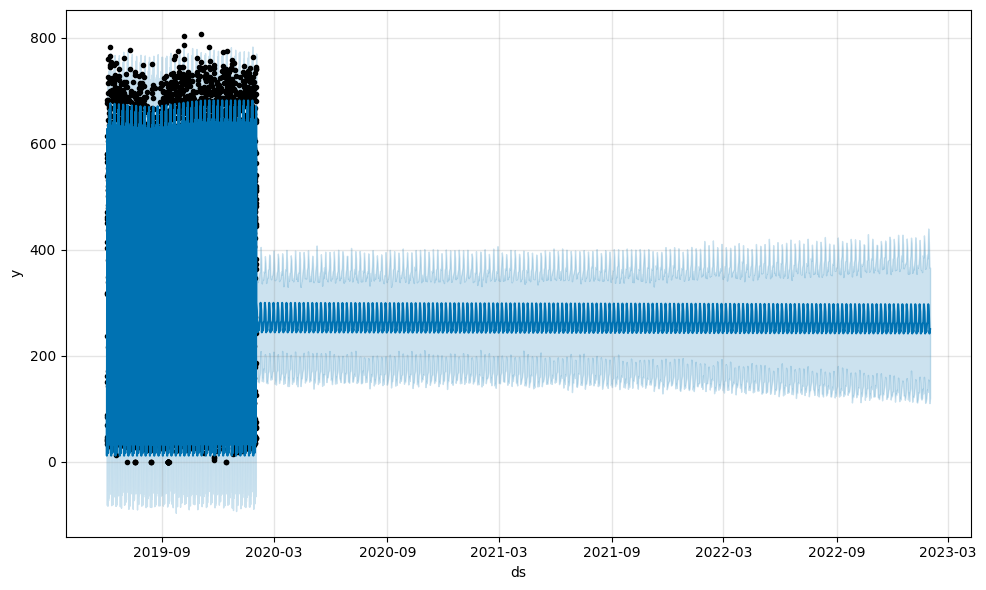

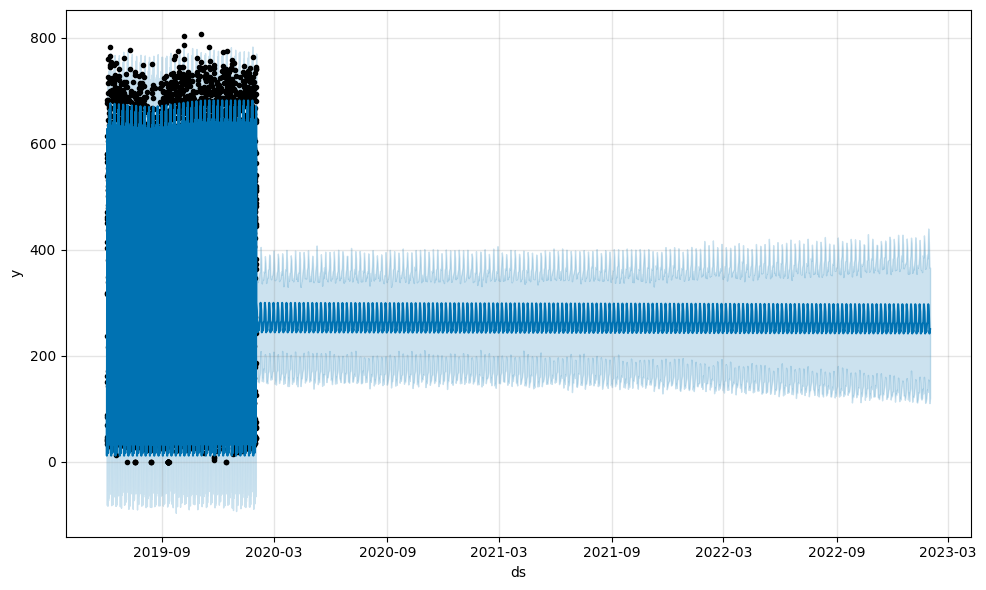

In [62]:
m.plot(forecast)

Now we can decompose the prediction.

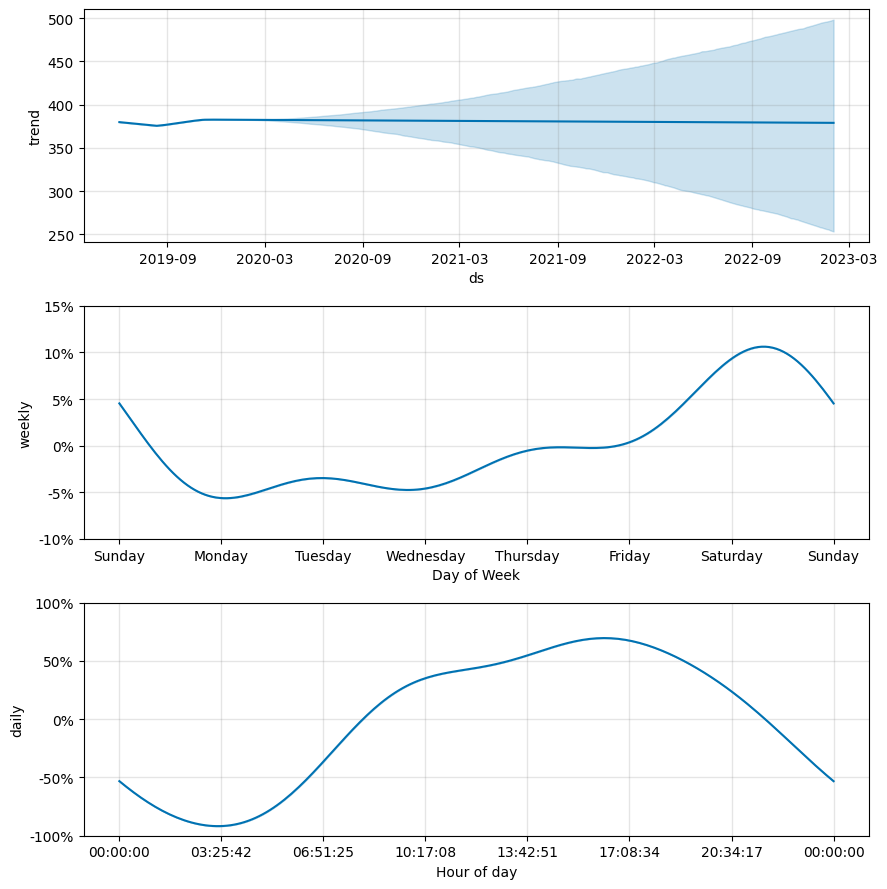

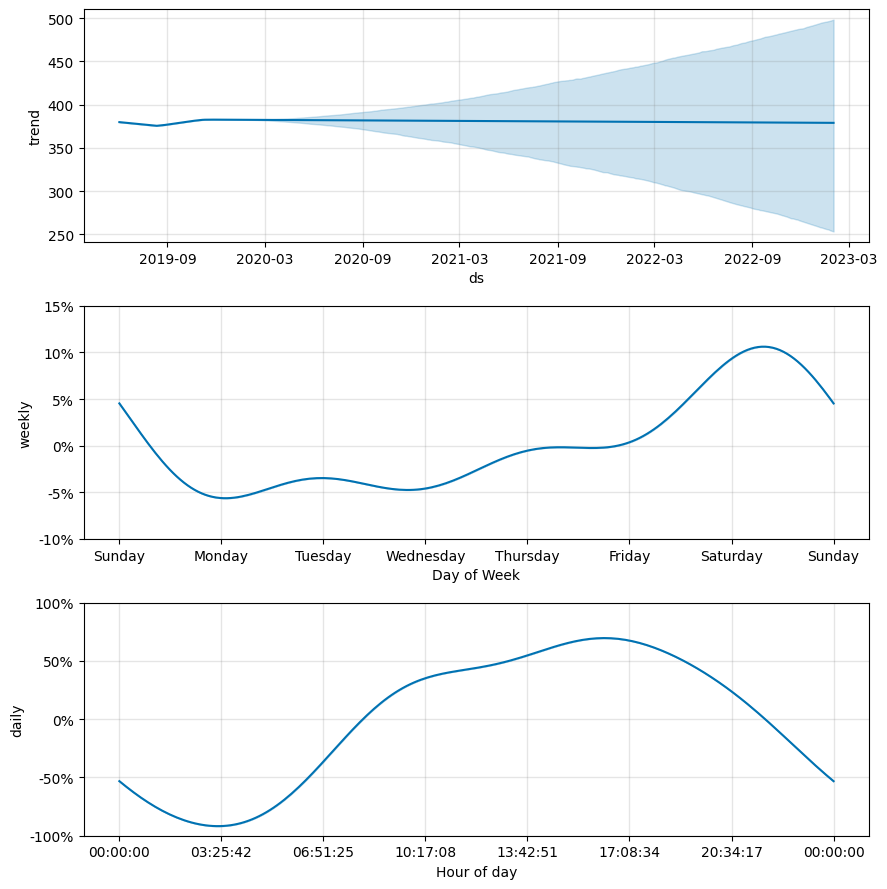

In [63]:
m.plot_components(forecast)

In [65]:
import logging
from prophet.diagnostics import cross_validation, performance_metrics

logging.getLogger('fbprophet').setLevel(logging.WARNING)

df_cv = cross_validation(m, initial='180 days', period='90 days', horizon='60 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2019-12-02 23:00:00 and 2019-12-02 23:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oktk2ue/xdno2wgq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6oktk2ue/xm5acjc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7316', 'data', 'file=/tmp/tmp6oktk2ue/xdno2wgq.json', 'init=/tmp/tmp6oktk2ue/xm5acjc0.json', 'output', 'file=/tmp/tmp6oktk2ue/prophet_modelwq8biyww/prophet_model-20240316191608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [66]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days 00:00:00,6439.615181,80.247213,63.485809,0.151806,0.206079,0.729167
1,6 days 01:00:00,6418.178569,80.113535,63.287536,0.151806,0.204475,0.729167
2,6 days 02:00:00,6415.874805,80.099156,63.247554,0.151806,0.204014,0.729167
3,6 days 03:00:00,6415.931561,80.099510,63.257517,0.151806,0.204300,0.729167
4,6 days 04:00:00,6413.832966,80.086409,63.197586,0.151806,0.203756,0.729167


In [68]:
#from prophet.plot import plot_cross_validation_metric
#fig = plot_cross_validation_metric(df_cv, metric='mape')
#plt.show()

# 3. Modelling Using Seasonal AutoRegressive Integrated Moving Average with eXogenous Factors (SARIMAX)

The plot below shows overall number of cars on the Mill Road over time. It looks like it has a linear character but a proper decomposition is required.

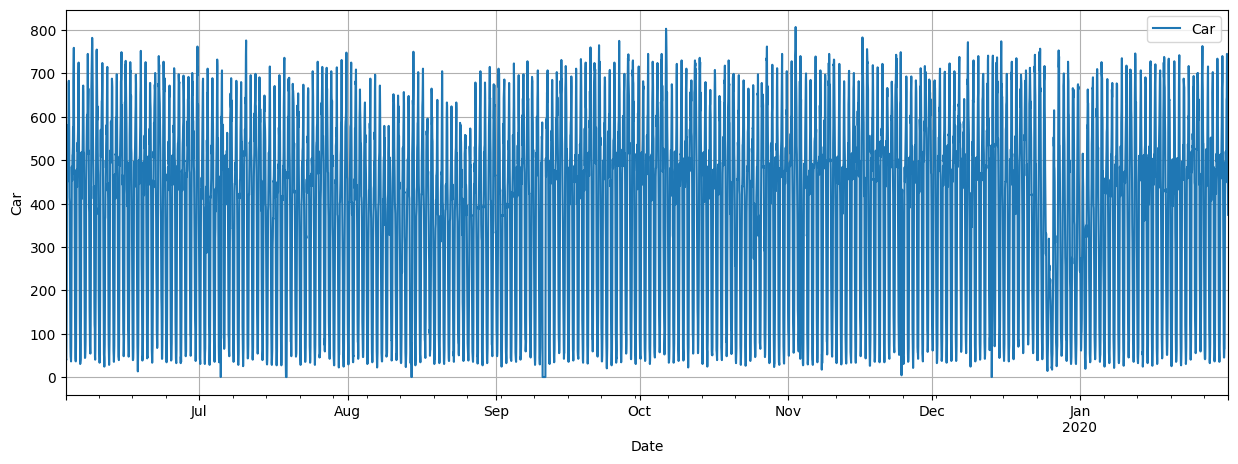

In [69]:
TS1 = data.groupby("LocalTime")["Car"].sum().to_frame()

fig, ax = plt.subplots(1,1,figsize=(15,5))
TS1.plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Car")
plt.grid(True)
plt.show()

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure).
* **Null Hypothesis (H0):** if failed to be rejected (high p-value) means it is non-stationary
* **Null Hypothesis (H1):** if H0 is rejected (low p-value) means it is stationary

In [70]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(TS1["Car"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -9.130517
p-value: 0.000000


To our surprise. P-value is 0.00 (we reject H0) - time series is stationary.

To better understand the time series behaviour I will decompose it into 3 main components:
* trend
* seasonality
* residuals

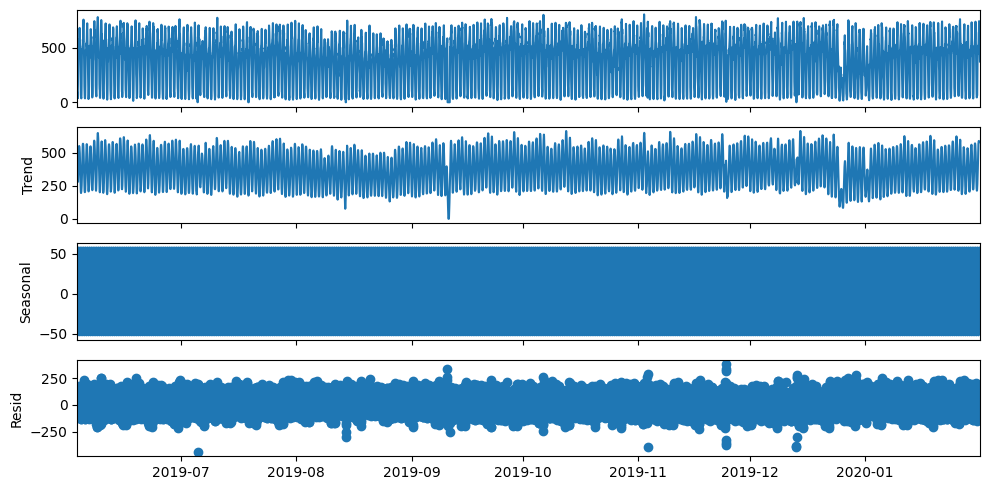

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = 10, 5
# Additive decomposition
decomposed_add = seasonal_decompose(TS1, model="additive",period=12)
add = decomposed_add.plot()
plt.show()

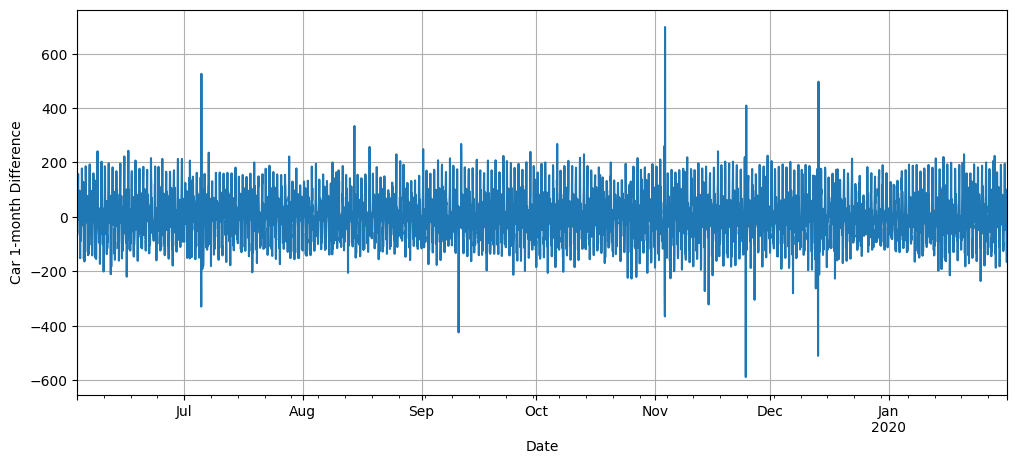

In [73]:
TS1_diff = TS1.diff().dropna()

plt.figure(figsize=(12,5))
ax = TS1_diff["Car"].plot()
ax.set_xlabel("Date")
ax.set_ylabel("Car 1-month Difference")
plt.grid(True)
plt.show()

In [74]:
results = adfuller(TS1_diff["Car"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -16.078835
P-value of a test is: 5.406107597266369e-29


The p-value of 1.1782140060417446e-29 is small enough to reject the null hipothesis that the time series is non-stationary. However, the plot above shows still a seasonality.

Let's see what would be result of the same test is we take a second difference. Pleas note that you have to be aware of risk of so called overdifferencing time series.

In [75]:
results = adfuller(TS1.diff().diff().dropna()["Car"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -36.349473
P-value of a test is: 0.0


Indeed the p-value test dropped even more. However, often the simplest solutions work the best - therefore I will stay with a simple single difference.

* **AutoCorrelation Plot** (ACF) shows a correlation between "a signal" (our value) with its delayed occurance (observation) in a function of time delta between them (so called lag).
* **Partial AutoCorrelation Plot** (PCAF) is similar to ACF but the effect of the shorter lags is removed.

Things to remember:

| Plot |       AR(p)      |       MA(q)      | ARMA(p,q) |
|:----:|:----------------:|:----------------:|:---------:|
|  ACF |     Tails off    | Cuts after lag q | Tails off |
| PACF | Cuts after lag p |     Tails off    | Tails off |

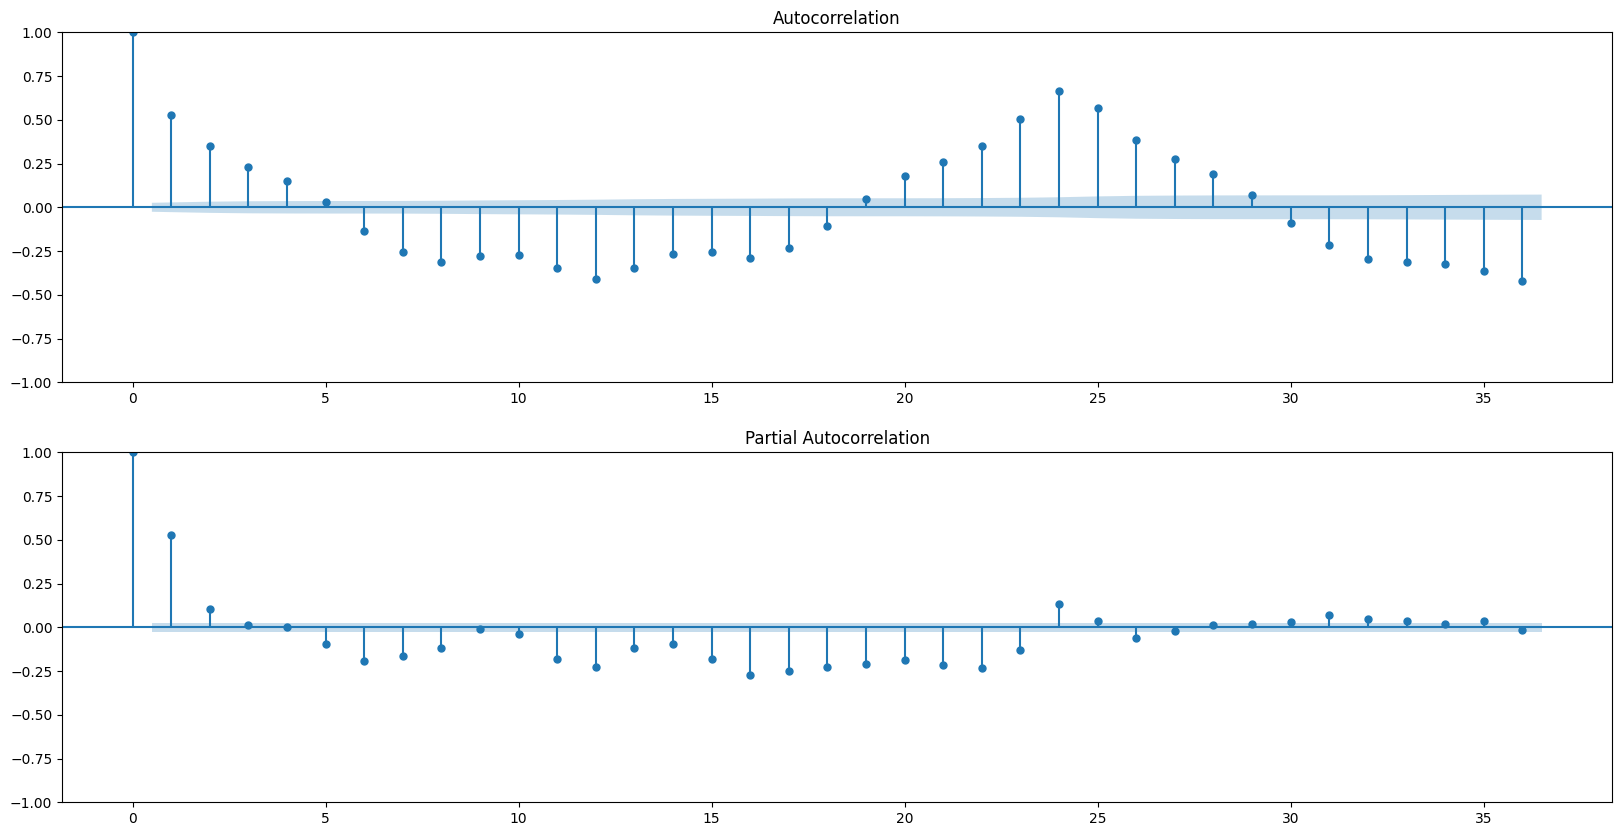

In [76]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(TS1_diff, lags=36, ax=ax[0])
plot_pacf(TS1_diff, lags=36, ax=ax[1])
plt.show()

The lag plot below allows to check a lag correlation. If you can identify a structure in the plot, the data doesn't look random and the autocorrelation is indeed present. In this case I will check the lag plot for lags of 5 and 6 months.


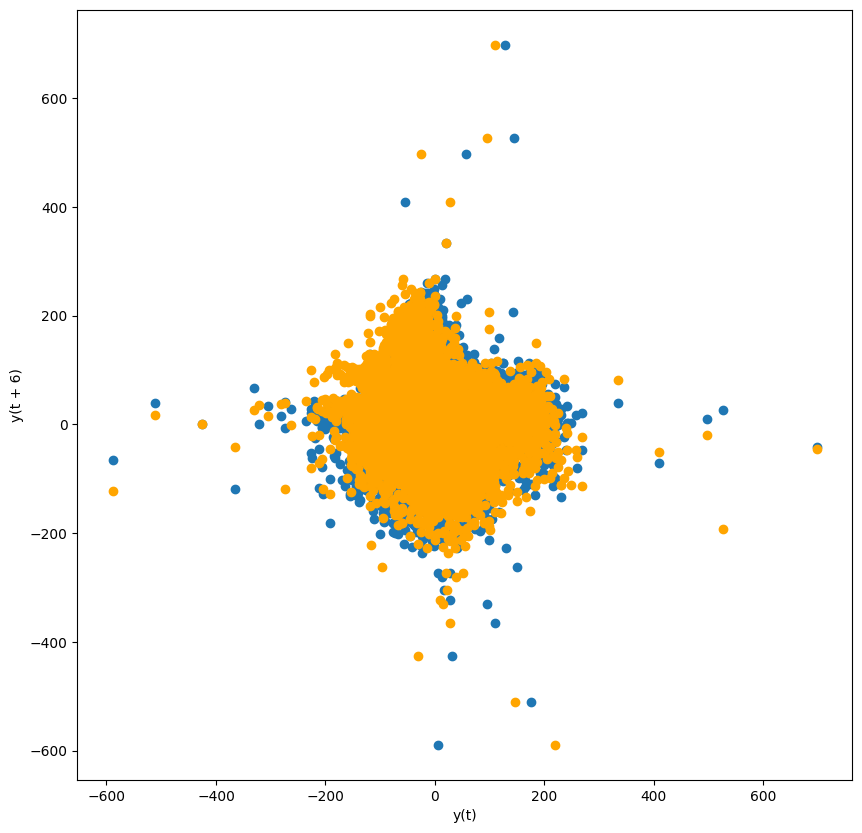

In [77]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(10, 10))
ax = lag_plot(TS1_diff, lag=5)
ax = lag_plot(TS1_diff, lag=6, c="orange")

plt.show()

In the next step we will iterate over p and q parameters of ARIMA model and compute for each **Akaike Information Critera (AIC)** and **Bayesian Information Criteria (BIC)**. BIC is giving additional penalty for more parameters.

In [78]:
from statsmodels.tsa.arima_model import ARIMA

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):

        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(TS1.astype(float), order=(p,1,q))
            results = model.fit()

            # Printing order, AIC and BIC
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            i = i+1

arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="sum_aic_bic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic


Let's look now at SARIMAX(2,1,1)x(0,1,0,12) diagnostics summary and diagnostics plots.

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
model2 = SARIMAX(TS1, order=(2,1,1), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 Car   No. Observations:                 5831
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood              -35118.384
Date:                             Sat, 16 Mar 2024   AIC                          70244.768
Time:                                     19:21:01   BIC                          70271.443
Sample:                                 06-03-2019   HQIC                         70254.046
                                      - 01-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5778      0.010    159.577      0.000       1.558       1.597
ar.L2         -0.6630      0.009    -76.818      0.000      -0.680      -0.646
ma.L1         -0.9997      0.017    -59.073      0.000      -1.033      -0.967
sigma2      1.024e+04    195.013     52.505      0.000    9856.868    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                 133.99   Jarque-Bera (JB):              3539.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Summary explanations:

1. **Ljung-Box (Q)** - This test is used to check for the *lack of fit* of a time series model. The null hypothesis here is there are no correlations in the residuals. In our case we reject the null hypothesis what means that residuals are somehow correlated.

2. **Jarque-Bera (JB)** - This is a test for normality of distributon. It is basing on values of skewness and kurtosis where for the normal distibution these values should be respectively 0 and 3. The null hypothesis of the test is that the sample comes from the normal distribution. Ander this hypothesis the chi-squared distribution with 2 degrees of freedom can be used. In our case JB statistics is 8.76 which gives probability of 0.01 - meaning that we don't reject the null hypothesis.

3. **Heteroskedasticity (H)** - Checks if the variance is constant

When looking at the diagnostic plots below we are interested in:
1. Standardized residual - there are no obvious patterns in the residuals
2. Histogram plus kde estimate - KDE should be very similar to the normal distribution
3. Normal Q-Q - points should lie on the straight line
4. Correlogram - 95% of correlations for lag greater than one should not be significant

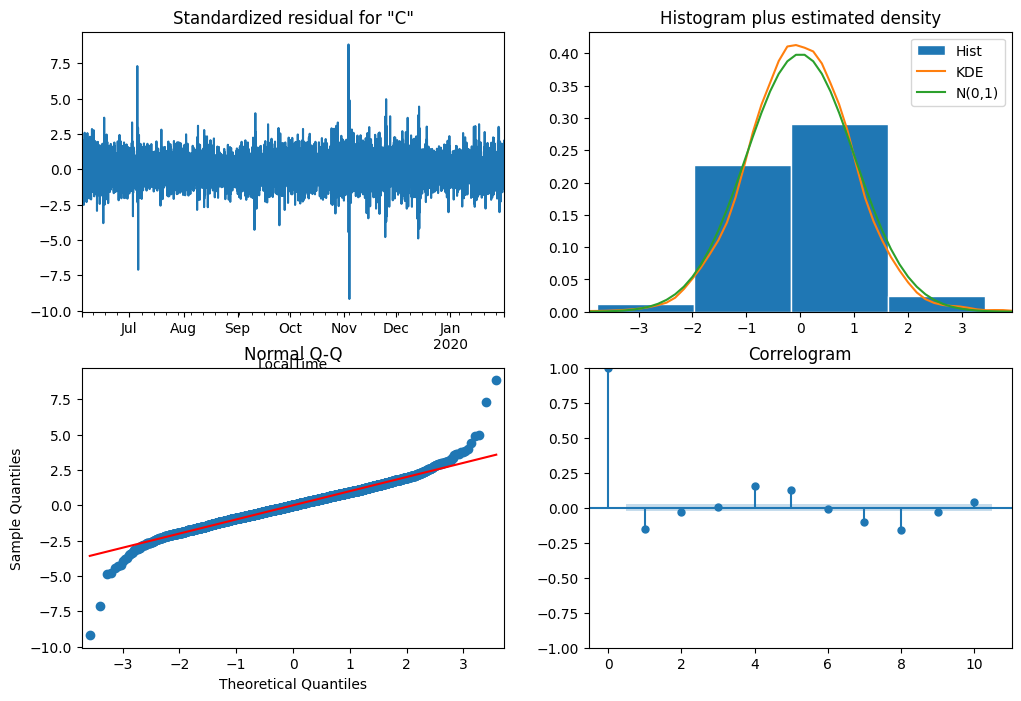

In [80]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()
plt.show()

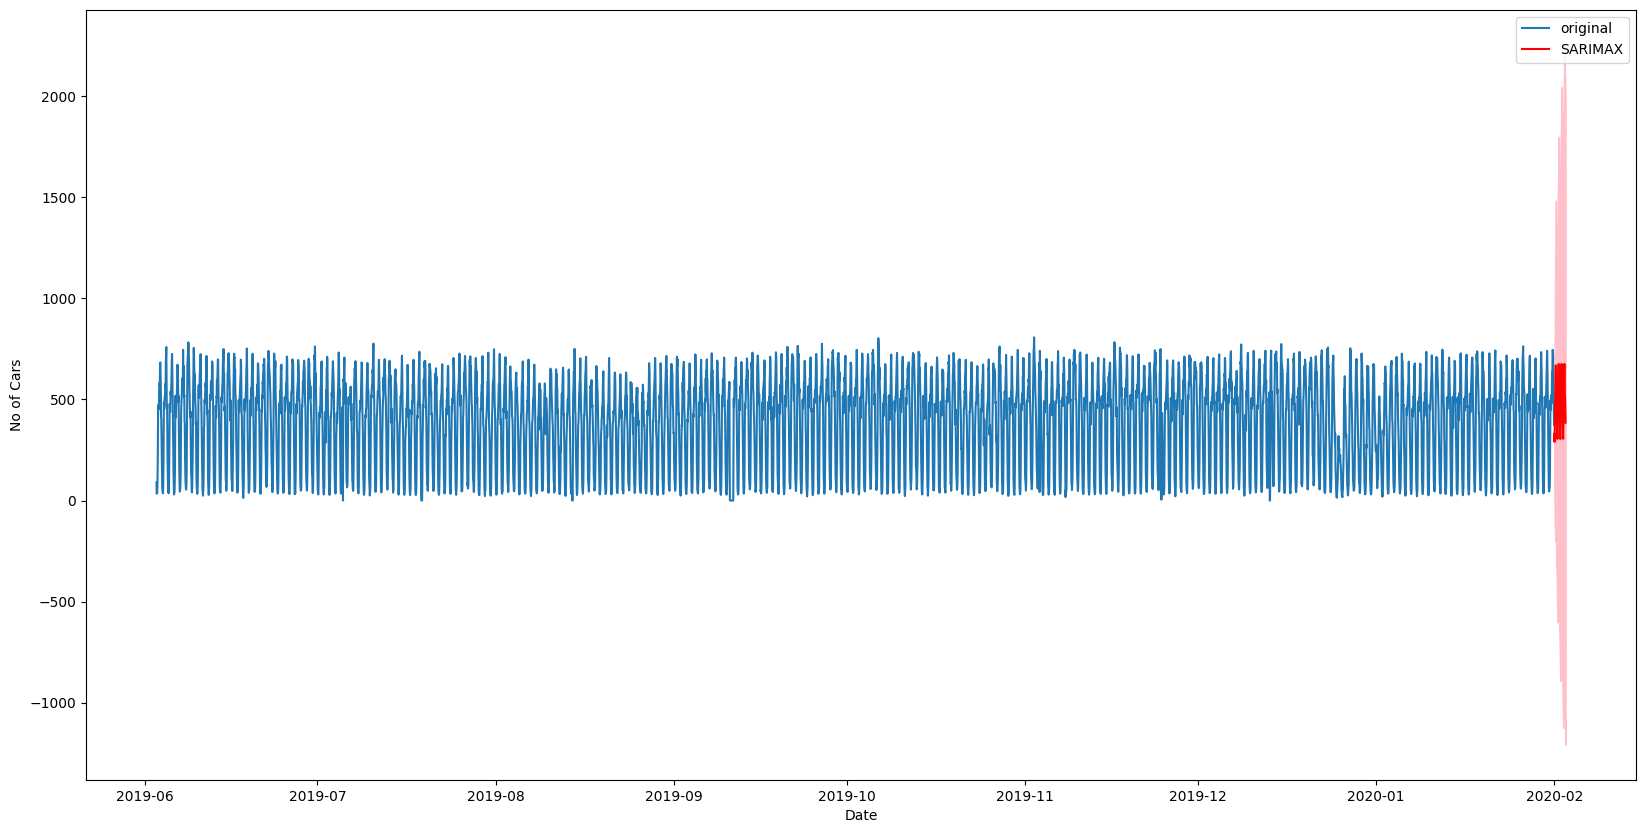

In [81]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=48)
lower = forecast.conf_int()["lower Car"]
upper = forecast.conf_int()["upper Car"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(TS1, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index,
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of Cars')
plt.legend()
plt.show()

The plot above shows predictions using SARIMAX(2,1,1)x(0,1,0,12). The red line indicates the mean and the pink area is bounded by 95% confidence intervals. According to this prediction in the month of February 2022, number of cars can reach two-thousand at the peak time.